## Simple simulated non-linear polynomial gain ODE

In [1]:
import jax
import equinox as eqx
import diffrax as dfx
import optimistix as optx
import jax.numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

### Define the base structure to solve the ODEs

In [2]:
import abc
from jax import grad, vmap

class Func(eqx.Module):

    @abc.abstractmethod
    def derivative(self, t, y, args):
        raise NotImplementedError

class ODESolver(eqx.Module):
    ODE: Func

    def __init__(self, ODE=None):
        self.ODE = ODE

    def __getattr__(self, name):
        if hasattr(self.ODE, name):
            return getattr(self.ODE, name)
        raise AttributeError(f"ODESolver.ODE has no attribute {name}")

    def solve_fn(self, illuminance):
        return dfx.diffeqsolve(
            terms=dfx.ODETerm(self.ODE.derivative),
            solver=dfx.Tsit5(),
            stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-3),
            adjoint=dfx.DirectAdjoint(),
            y0=np.zeros_like(illuminance),
            args=(illuminance),
            t0=np.array(0.0),
            t1=np.array(1.0),
            dt0=np.array(0.01),
            saveat=dfx.SaveAt(ts=np.linspace(0, 1, 10)),
            max_steps=1000,
        )

### Define the Polynomial function, and the Gain ODE

In [3]:
class BasePolynomial(eqx.Module):
    powers: tuple = eqx.field(static=True)
    coeffs: np.ndarray

    def __init__(self, powers, coeffs):
        for p in powers:
            if not isinstance(p, int):
                raise ValueError("Powers must be integers.")
        self.powers = powers
        self.coeffs = coeffs

    def evaluate(self, x):
        return np.sum(self.coeffs * x ** np.array(self.powers))

    def evaluate_arr(self, arr):
        return vmap(self.evaluate)(arr.flatten()).reshape(arr.shape)


class GainODE(Func, BasePolynomial):

    def __init__(self, nterms=3):
        self.powers = (1, 2, 3)
        self.coeffs = np.zeros(len(self.powers))

    def dgain_dt(self, t, illuminance):
        grad_fn = grad(lambda t, x: self.evaluate(t * x))
        grad_fn_vmap = vmap(lambda t, x: grad_fn(t, x), (None, 0))
        grad_fn_2d = lambda t, arr: grad_fn_vmap(t, arr.flatten()).reshape(arr.shape)
        return grad_fn_2d(t, illuminance)

    def derivative(self, t, charge, illuminance):
        dqdt = self.dgain_dt(t, illuminance)
        return dqdt

### Create a fake gaussian illumination source with a given polynomial gain

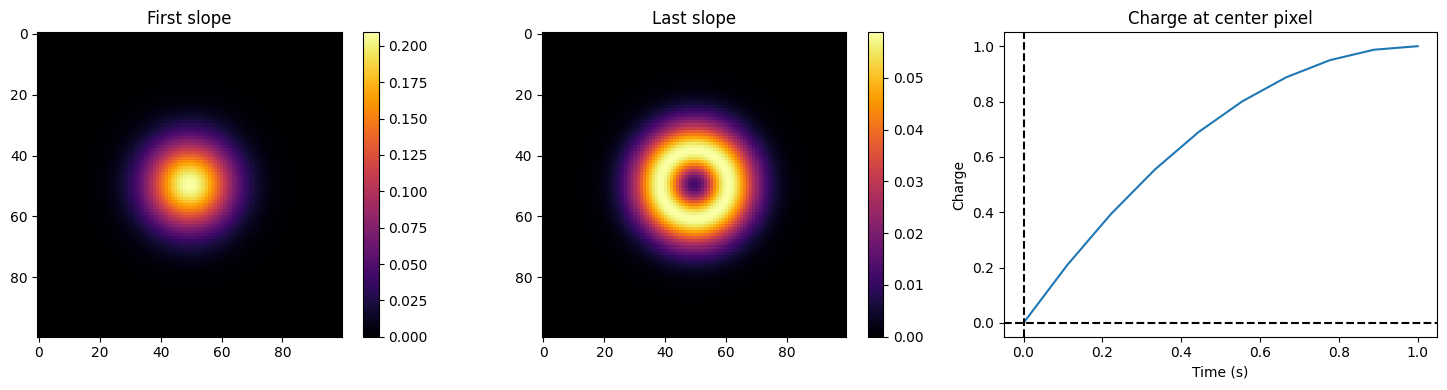

In [4]:
coeffs = np.array([2, -1, 0.0])
poly = BasePolynomial((1, 2, 3), coeffs)

# Gaussian distribution - the illuminance
xs = np.linspace(-5, 5, 100)
coords = np.meshgrid(xs, xs)
illuminance = np.exp(-0.5 * np.hypot(*coords) ** 2)

# Polynomial of the illuminance - the charge
ts = np.linspace(0, 1, 10)
charge_ramp = np.array([poly.evaluate_arr(t * illuminance) for t in ts])
charge_slopes = np.diff(charge_ramp, axis=0)

# Plot
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("First slope")
plt.imshow(charge_slopes[0], "inferno")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Last slope")
plt.imshow(charge_slopes[-1], "inferno")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.plot(ts, charge_ramp[:, 50, 50])
plt.axhline(0, color="black", linestyle="--")
plt.axvline(0, color="black", linestyle="--")
plt.title("Charge at center pixel")
plt.xlabel("Time (s)")
plt.ylabel("Charge")

plt.tight_layout()
plt.show()

### Define the residual function and solver

In [5]:
@eqx.filter_jit
@eqx.debug.assert_max_traces(max_traces=1)
def residuals(ode_model, args):
    illuminance, charge_slopes = args
    pred = ode_model.solve_fn(illuminance).ys
    return charge_slopes - np.diff(pred, axis=0)


init_parameters = ODESolver(GainODE())
args = ( illuminance, charge_slopes)

# Solver
solver = optx.LevenbergMarquardt(
    rtol=1e-8, atol=1e-8, verbose=frozenset({"step", "accepted", "loss", "step_size"})
)
sol = optx.least_squares(residuals, solver, init_parameters, args=args)

print(sol.value.coeffs)

Step: 0, Accepted steps: 0, Steps since acceptance: 0, Loss on this step: 34.17674652421957, Loss on the last accepted step: 0.0, Step size: 1.0
Step: 1, Accepted steps: 1, Steps since acceptance: 0, Loss on this step: 0.26854164901114225, Loss on the last accepted step: 34.17674652421957, Step size: 3.5
Step: 2, Accepted steps: 2, Steps since acceptance: 0, Loss on this step: 0.026623939191270818, Loss on the last accepted step: 0.26854164901114225, Step size: 12.25
Step: 3, Accepted steps: 3, Steps since acceptance: 0, Loss on this step: 0.0008498454416389649, Loss on the last accepted step: 0.026623939191270818, Step size: 42.875
Step: 4, Accepted steps: 4, Steps since acceptance: 0, Loss on this step: 2.92125167839328e-06, Loss on the last accepted step: 0.0008498454416389649, Step size: 150.0625
Step: 5, Accepted steps: 5, Steps since acceptance: 0, Loss on this step: 8.929423592950545e-10, Loss on the last accepted step: 2.92125167839328e-06, Step size: 525.21875
Step: 6, Accepte

### Look at the well-fit ODE!

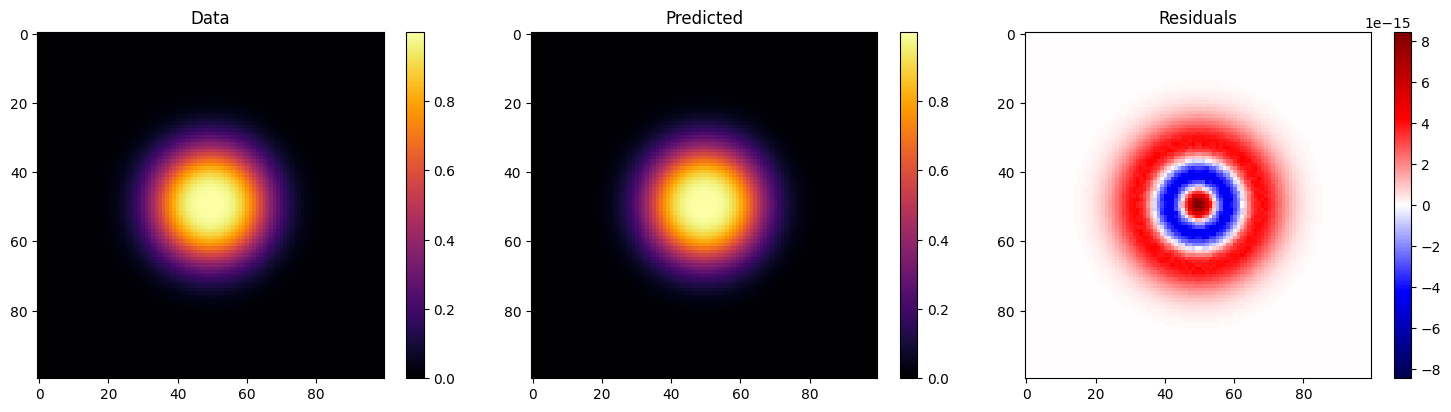

In [6]:
predicted_ramp = sol.value.solve_fn(illuminance).ys
predicted_slopes = np.diff(predicted_ramp, axis=0)

res = charge_slopes.sum(0) - predicted_slopes.sum(0)
v = np.nanmax(np.abs(res))

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Data")
plt.imshow(charge_slopes.sum(0), "inferno")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Predicted")
plt.imshow(predicted_slopes.sum(0), "inferno")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residuals")
plt.imshow(res, "seismic", vmin=-v, vmax=v)
plt.colorbar()

plt.tight_layout()
plt.show()